In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import cv2
from  matplotlib.colors import LinearSegmentedColormap
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, find_peaks, savgol_filter
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from scipy.io import savemat
from src.xray import *
from src.tdt_support import *
from src.filters import *
from src.neural_analysis import *
from src.cort_processing import *
from src.wiener_filter import *


In [3]:
tdt1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-220303-161731'
kin1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15_2022-03-03_200f-11e100g1.csv'
toe1 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15_2022-03-03_200f-11e100g1.csv'
np_ts1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15_2022-03-03_200f-11e100g1.npy'
crop1 = (5,180)

tdt2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-2-220303-162513'
kin2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-2_2022-03-03_200f-11e100g1.csv'
toe2 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-2_2022-03-03_200f-11e100g1.csv'
np_ts2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-2_2022-03-03_200f-11e100g1.npy'
crop2 = (31,227)

tdt3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-3-220303-163055'
kin3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-3_2022-03-03_200f-11e100g1.csv'
toe3 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-3_2022-03-03_200f-11e100g1.csv'
np_ts3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-3_2022-03-03_200f-11e100g1.npy'
crop3 = (5,200)

tdt4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-4-220303-163556'
kin4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-4_2022-03-03_200f-11e100g1.csv'
toe4 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-4_2022-03-03_200f-11e100g1.csv'
np_ts4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-4_2022-03-03_200f-11e100g1.npy'
crop4 = (5,150)

In [4]:
rates1, angles1= process_neural_kinangles(tdt1, kin1, np_ts1, 3.0, crop1, binsize=0.05, toe_height_path = toe1)
rates2, angles2= process_neural_kinangles(tdt2, kin2, np_ts2, 3.0, crop2, binsize=0.05, toe_height_path = toe2)
rates3, angles3= process_neural_kinangles(tdt3, kin3, np_ts3, 3.0, crop3, binsize=0.05, toe_height_path = toe3)
rates4, angles4= process_neural_kinangles(tdt4, kin4, np_ts4, 3.0, crop4, binsize=0.05, toe_height_path = toe4)

#test_rates5, test_angles5 = process_neural_kinangles(tdt4, kin4, np_ts4, 3.0, test_crop, binsize=0.05)

rates_list = []
angles_list = []

rates_list.extend((rates1, rates2, rates3, rates4))
angles_list.extend((angles1, angles2, angles3, angles4))

read from t=0s to t=209.21s
read from t=0s to t=242.15s
read from t=0s to t=206.37s
read from t=0s to t=157.26s


In [5]:
proc_rates_list = []
proc_angles_list = []
for i in range(len(rates_list)):
    proc_rates, proc_angles = remove_bad_gaits(rates_list[i], angles_list[i], 115)
    proc_rates_list.append(proc_rates)
    proc_angles_list.append(proc_angles)

In [6]:
proc_rates, proc_kins = stitch_data(proc_rates_list, proc_angles_list)
rates, kins = stitch_data(rates_list, angles_list)

In [7]:
h, vaf_array, test_x, test_y = decode_kfolds(rates, kins)
proc_h, proc_vaf_array, proc_test_x, proc_test_y = decode_kfolds(proc_rates, proc_kins)

In [23]:
avg = np.average(proc_vaf_array[:-1,:], axis=1)
std = np.std(proc_vaf_array[:-1,:], axis=1)


<BarContainer object of 8 artists>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
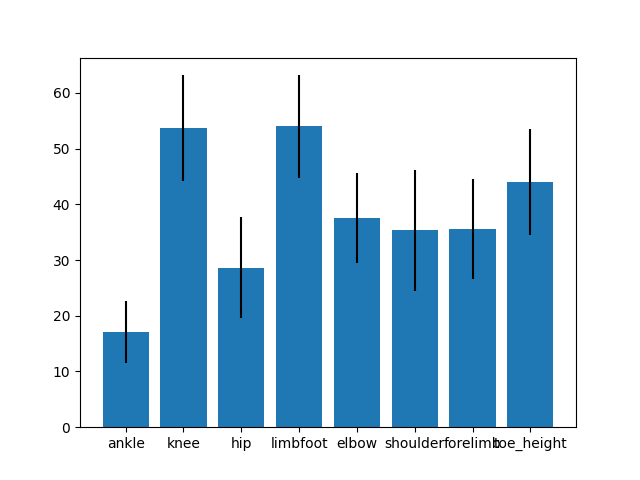

In [29]:
x=['ankle', 'knee', 'hip', 'limbfoot', 'elbow', 'shoulder', 'forelimb', 'toe_height']


figa = plt.figure()
axa= figa.add_subplot(111)
axa.bar(x, avg*100, yerr=std*100)

In [8]:
clf, acc_list, fin_test_x, fin_test_y = classify_kfolds(proc_rates, proc_kins[:,-1])

In [9]:
y_pred = clf.predict(fin_test_x)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
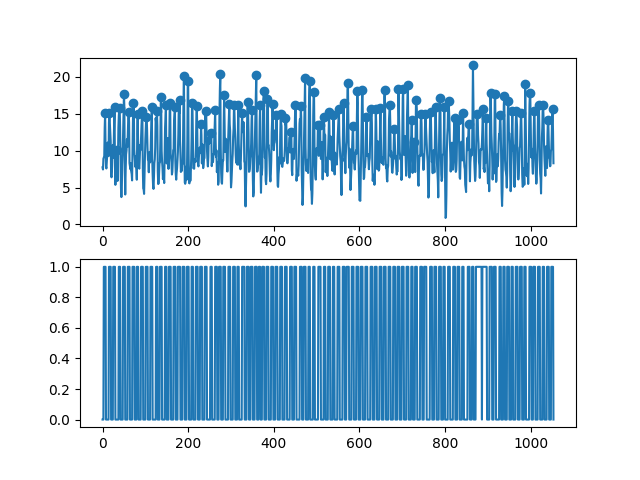

In [41]:
kin_predic = test_wiener_filter(proc_test_x, proc_h)
forelimb_predic = kin_predic[:,-2]
smoothed = savgol_filter(forelimb_predic, 9,3)
fig0 = plt.figure()
ax0 =fig0.add_subplot(211)
ax0.plot(forelimb_predic)
ax0.scatter(peaks,forelimb_predic[peaks])
ax00=fig0.add_subplot(212, sharex=ax0)
ax00.plot(proc_test_y[:,-1])

In [39]:
peaks, prominences = find_peaks(forelimb_predic, prominence=4)

In [35]:
peaks

array([   6,   16,   28,   40,   50,   61,   72,   82,   93,  102,  115,
        127,  136,  148,  157,  169,  180,  190,  199,  209,  220,  230,
        242,  263,  275,  284,  296,  307,  317,  326,  339,  349,  359,
        368,  377,  385,  397,  416,  427,  450,  463,  473,  484,  493,
        503,  517,  529,  539,  552,  563,  573,  585,  595,  607,  616,
        628,  638,  649,  659,  671,  681,  691,  702,  713,  722,  732,
        744,  754,  766,  778,  788,  798,  808,  822,  829,  842,  855,
        865,  874,  888,  896,  906,  916,  929,  938,  947,  957,  966,
        977,  987,  998, 1008, 1019, 1028, 1040, 1051])

0.8358633776091081


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
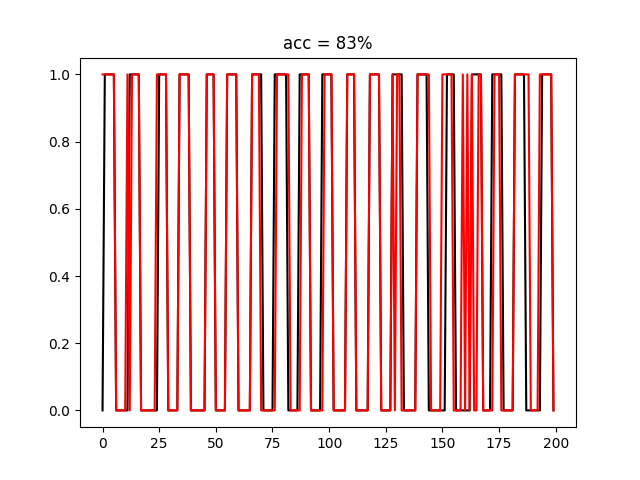

In [17]:
fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.plot(fin_test_y[100:300], c='black')
ax0.plot(y_pred[100:300], c='red')
ax0.title.set_text('acc = 83%')
print(np.max(np.array(acc_list)))

fig0.savefig('/home/diya/Documents/rat-fes/results/forelimb_figs/stance_swing_decode')